In [1]:
from QHD import *

import matplotlib.pyplot as plt
import numpy as np

# The Morse Potential

For this first module, we will be looking at a morse potential.

### 1. The Potential

We first must define the potential along with its parameters, as described below for the O-H stretch in a water molecule.

**Parameters**

$D = 4.419 eV$

$\alpha = 2.567 A^{(-1)}$

$q_0 = 0 A$




**Potential**

$V(q) = D*(1-e^{-\alpha(q-q_0)})^2$

We can define this potential as `potential`, and define the given parameters as `D`, `alpha`, and `q_0` as described below. We will also need to define the dependent variable, in this case `q` as a range using the `linspace` function found in `numpy`. The parameters are all in *atomic units*.

In [2]:
D = 4.419 #*0.0367493 # eV -> Hartree
D1 = 1 #*0.0367493 # eV -> Hartree
D2 = 10 #*0.0367493 # eV -> Hartree
alpha = 2.567 # Angstrom(-1) 
q_0 = 0 # Angstrom
q = np.linspace(-10, 10, 1000) # Angstrom

potential = D * (1 - np.exp(-alpha*(q-q_0)))**2
potential1 = D1 * (1 - np.exp(-alpha*(q-q_0)))**2
potential2 = D2 * (1 - np.exp(-alpha*(q-q_0)))**2

# Above values given in QHD paper for water O-H stretch

Now that the parameters and potential have been defined, the potential can be plotted using the `matplotlib.pyplot` library. Any of the lines can be changed as desired.

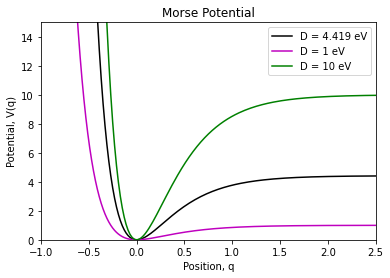

In [3]:
plt.plot(q, potential, 'k')
plt.plot(q, potential1, 'm')
plt.plot(q, potential2, "g")
plt.legend(["D = 4.419 eV", "D = 1 eV", "D = 10 eV"])
plt.title("Morse Potential") # Title of the graph
plt.ylim(0, 15) # (Lower, Upper) limit of the y-axis
plt.ylabel("Potential, V(q)") 
plt.xlim(-1, 2.5) # (Lower, Upper) limit of the x-axis
plt.xlabel("Position, q")
plt.savefig('morse_vVq.png') # Save to this file name, as a png file
plt.show()

### 2. Derivation of  QHD formulas

Here, we use the pysces library, able to derive the equations of motion in the QHD method. We will need to define the `q`, `p`, `p2`, `x`, `x2`, and `xp` variables. In order to do this, we must first calculate the first and second derivatives of the potential of interest, defined in section 1. We will also use a change of variables as well, described below.

**2.1 The First and Second Derivatives of the Potential**

To take the derivatives, we must represent the potential symbolically. This can be done by:

In [4]:
# First, we must define all the parameters as stated in section 1 as symbols:

D, alpha, q = symbols("D, alpha, q")
q_0 = 0.0

# When computing symbolically, we do not need to use the numpy exponential function.

potential_sym = D * (1 - exp(-alpha*(q-q_0)))**2

Now that the potential is represented symbolically, we may take the first and second derivatives, described by diff1 and diff2, respectively

In [5]:
diff1 = diff(potential_sym, q)
diff2 = diff(diff1, q)

diff1, diff2

**2.2 Change of Variable**

We can do a change of variable in the potential to:

$$x=e^{-\alpha q}$$

And so:

$$V(q)=D[x^2-2x]$$

We will now take the first and second derivatives of the original potential, and then perform the change of variables.

- The First Derivative:

In [6]:
x = Symbol("x")

diff11 = diff1.replace(exp(-alpha*(q-q_0)), x).replace(exp(-2*alpha*(q-q_0)), x**2)

diff11

- The Second Derivative:

In [7]:
diff22 = diff2.replace(exp(-alpha*(q-q_0)), x).replace(exp(-2*alpha*(q-q_0)), x**2)

diff22

We can now solve for the equations of motion.

**2.3 Solving for the Equations of Motion**

We must solve the equations of motion for `q`, `p`, `x`, `x2`, and `xp` using the parameters defined in section 1.

In [10]:
# Again, we must first define all variables as symbols. #

q, p, p2, x, x2, xp, dt, mass, D, alpha = symbols("q, p, p2, x, x2, xp, dt, mass, D, alpha")
q_0 = 0.0
########## EOM Calculations ##########

# If you want to see the output of any of the below, uncomment the desired print line. #

# There are two ways to derive the EOM's, using the `time_deriv` function and then the original way is with `QHD_int`
# The `time_deriv` function is used as it's more versatile at this time, however it's still not perfect.
# `QHD_int` uses the `time_deriv` function

px = xp
q1 = str(time_deriv(q, 1)*dt + q)
print("q = " + str(q1))

x = exp(-alpha*q)
x1 = sympify(str(time_deriv(x, 1)).replace("exp(-alpha*q)", "x"))
x1 = str((symmetrize(x1))*(0.5)*dt + Symbol("x"))
print("x = " + str(x1))

p1 = str(time_deriv(p, 1)).replace("v(q)", str(potential_sym))
p1 = expand(sympify(p1).doit())
p1 = str(p1).replace("exp(-2*alpha*q)", "x2").replace("alpha**2", "0")
p1 = sympify(p1)
p1 = str(symmetrize(p1)*(0.5)*dt + p).replace("exp(-alpha*q)", "x")
print("p = " + str(p1))

x = Symbol("x")
p21 = str(time_deriv(p, 2)).replace("v(q)", str(potential_sym))
p21 = expand(sympify(p21).doit())
p21 = str(-p21).replace("exp(-alpha*q)", "x").replace("exp(-2*alpha*q)", "x2").replace("alpha**2", "0")
p21 = str(symmetrize(p21)*(0.5)*dt + p2).replace("exp(-alpha*q)", "x").replace("exp(-2*alpha*q)", "x2")
print("p2 = " + str(p21))

q = dt*p/mass + q
x = -0.5*alpha*dt*xp/mass + x
p = dt*(1.0*D*alpha*x2 - 1.0*D*alpha*x) + p
p2 = dt*(-2.0*D*alpha*xp + 2.0*D*alpha*(-2*p*x**2 + p*x2 + 2*x*xp)) + p2


In [11]:
alp = alpha

def integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,dt,mass,alp,D):
    x2 = x2 - 4.0*(alp/mass)*x*(xp - x*p)*0.5*dt
    x2 = exp(-2.0*alp*p*dt/mass)*x2
    x2 = x2 - 4.0*(alp/mass)*x*(xp - x*p)*0.5*dt
    return x2

def integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,dt,mass,alp,D):
    xp = xp + 0.5*dt*(2.0*alp*D*(x*(3.0*x2 - 2*x*x) - x2)  - (alp*x/mass)*(p2 - 2.0*p*p) )
    xp = exp(-2.0*alp*p*dt/mass)*xp
    xp = xp + 0.5*dt*(2.0*alp*D*(x*(3.0*x2 - 2*x*x) - x2)  - (alp*x/mass)*(p2 - 2.0*p*p) )
    return xp

Now, we are ready to make plots of the data based on the EOM's as computed above.

# 3. Graphing

**3.1 Generating Time-Dependent Values**

We will first define all of the parameters necessary to perform the QHD calculations.

In [38]:
##### Constants #####

hbar = 0.6582  # eV * fs
convert = (1.0/17.586)
mass, q0, p0, s0, ps0, T, dt = 2980.0*convert, 0.15, 0.0, 0.05, 0.0, 500, 0.1
alp = 2.567
alpha = alp


D = 4.419
#D = 1
#D = 10

##### Initial Conditions #####

t = 0.0    
Etot = 0.0
Etot0 = 0.0
Etot_cl = 0.0
Etot_cl0 = 0.0
q,p,pq,q2,p2,x,x2,xp,xq = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
q, p = q0, p0
q_0 = 0.0
q2 = q*q + s0*s0
pq = ps0*s0 + q*p
p2 = p*p + ps0*ps0 + (0.5*hbar/s0)**2
x = math.exp(-alp*q0)*math.exp(0.5*alp*alp*s0*s0)
x2 = math.exp(-2.0*alp*q0)*math.exp(2.0*alp*alp*s0*s0)
xq = x*(q-alp*s0*s0)
xp = x*(p - s0*ps0*alp)

##### ----- #####

xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

x = eval(x1)

p2 = eval(p21)

p = eval(p1)

q = eval(q1)

p = eval(p1)

p2 = eval(p21)

x = eval(x1)

x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

##### Empty Lists for Data Storage: #####

q_list = [] 
p_list = []

Now that the parameters have been defined, we can compute the desired values of position and energy over a given time interval.

In [39]:
### Time how long it takes to compute ###

import time 
begin = time.time()


### Compute the x values ###

dt = 0.1 # step size
t_i = 0.0 # start
t_f = 1000 # finish


### Compute the y values ###

i=0
while i<1:        
    s = (q2 - q*q)
    if s>0.0:
        s = math.sqrt(s)
    else: 
        s = 0.0
    if s>0.0:
        ps = (pq - p*q)/s
    else: 
        ps = 0.0
    i = i+1


while t_i<=t_f:
    xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

    x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

    x = eval(x1)

    p2 = eval(p21)

    p = eval(p1)

    q = eval(q1)

    p = eval(p1)

    p2 = eval(p21)

    x = eval(x1)

    x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

    xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)


    t_i = t_i + dt
    i=0
    while i<1:
        s = (q2 - q*q)
        if s>0.0:
            s = math.sqrt(s)
        else: 
            s = 0.0
        if s>0.0:
            ps = (pq - p*q)/s
        else: 
            ps = 0.0

        i = i+1
        q_list.append(q)
        p_list.append(p)


### Compute the end time ###
    
time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime is {end - begin}")

Total runtime is 44.89966940879822


The above cell takes about 40-45 seconds to run for `t_f = 1000`

For the x values, we create a range with `(t_i, t_f, dt)` as the parameters. Due to the increasing nature of `t_i`, the initial value of `0.0` is used in its place.

In [40]:
### Define the x values ###

x_list = np.arange(0, t_f, dt)

**3.2 Graphing Position versus Time**

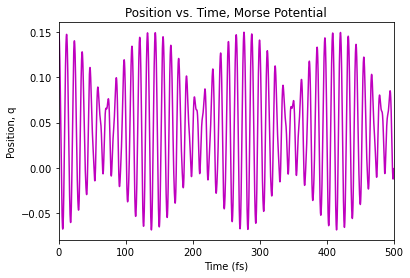

In [41]:
plt.plot(x_list, q_list, 'm')
plt.title("Position vs. Time, Morse Potential")
plt.xlim(0, 500)
plt.xlabel("Time (fs)")
#plt.ylim(-0.5, 0.5)
plt.ylabel("Position, q")
plt.show()

**3.2.1 Graphing Potential versus Time**

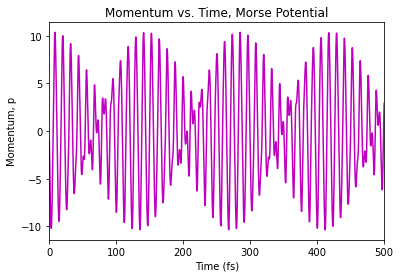

In [42]:
plt.plot(x_list, p_list, 'm')
#plt.plot([0, 5000], [0, 0], "k")
plt.title("Momentum vs. Time, Morse Potential")
plt.xlim(0, 500)
plt.xlabel("Time (fs)")
#plt.ylim(-0.5, 0.5)
plt.ylabel("Momentum, p")
plt.show()

In [ ]:
# Maybe don't do energy...

**3.3 Energy versus Time**

ValueError: x and y must have same first dimension, but have shapes (10000,) and (0,)

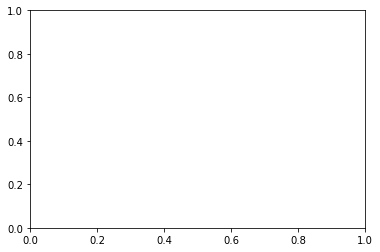

In [25]:
#plt.plot(x_list, e_list0)
plt.plot(x_list, e_list1, "k")
plt.plot(x_list, e_list2, "m")
plt.legend(["Classical E", r"E/$E_0$"])
#plt.plot([0, 500], [0, 0], "k-")
plt.title("Energy vs. Time, D = 4.419 eV")
plt.xlim(0, 20)
plt.xlabel("Time (fs)")
#plt.ylim(0, 2)
plt.ylabel("Energy, eV")
plt.savefig('morse_eVt.png')
plt.show()